<a href="https://colab.research.google.com/github/2303a52443/GAI_2303a52443/blob/main/GEN_AI_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning into 'shap-e'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 336 (delta 35), reused 13 (delta 13), pack-reused 281 (from 2)
Receiving objects: 100% (336/336), 11.72 MiB | 18.73 MiB/s, done.
Resolving deltas: 100% (43/43), done.
/content/shap-e
Obtaining file:///content/shap-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-xddbfnlc/clip_783553a1c04c427481ce7ac0c7a9928a
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-xddbfnlc/clip_783553a1c04c427481ce7ac0c7a9928a
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

/content/shap-e/shap_e/models/nn/checkpoint.py:31: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/content/shap-e/shap_e/models/nn/checkpoint.py:43: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/content/shap-e/shap_e/models/nn/checkpoint.py:61: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/content/shap-e/shap_e/models/nn/checkpoint.py:86: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


  0%|          | 0.00/1.78G [00:00<?, ?iB/s]

100%|███████████████████████████████████████| 890M/890M [00:11<00:00, 78.2MiB/s]


  0%|          | 0.00/1.26G [00:00<?, ?iB/s]

Models loaded successfully.


  0%|          | 0/64 [00:00<?, ?it/s]

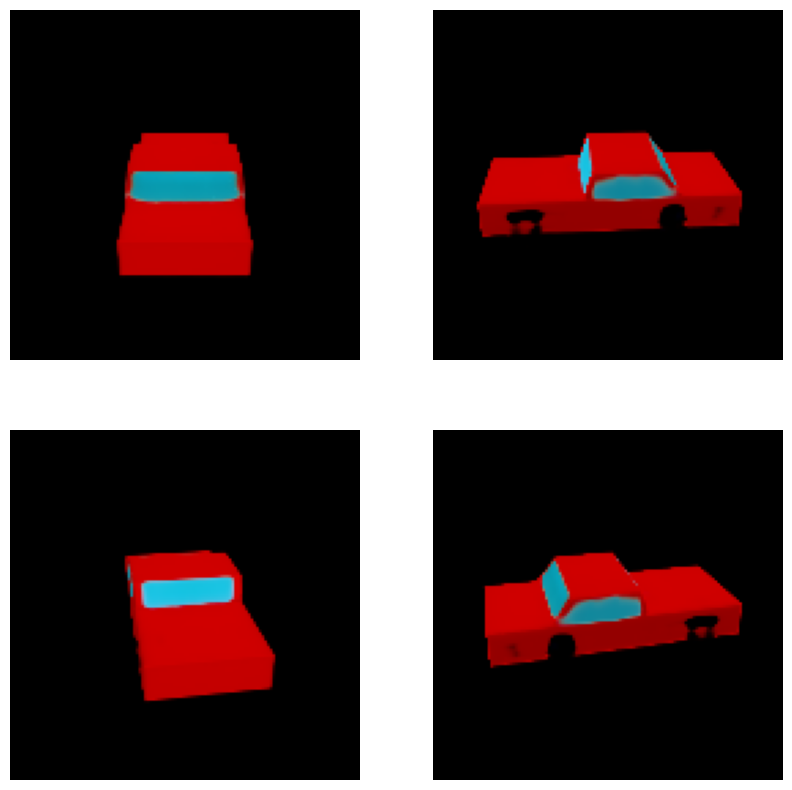

  0%|          | 0/64 [00:00<?, ?it/s]

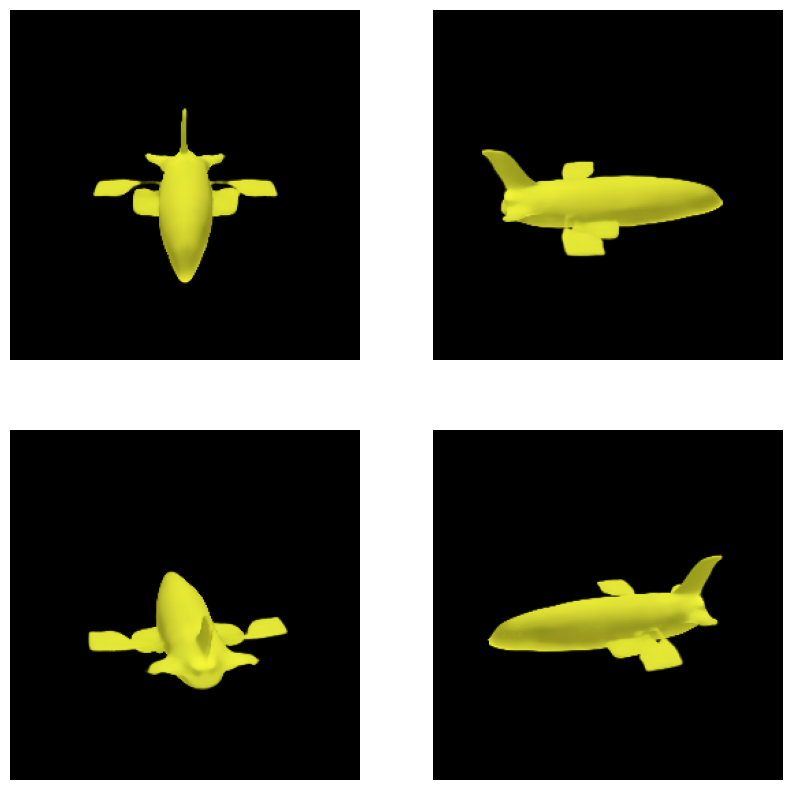

  0%|          | 0/64 [00:00<?, ?it/s]

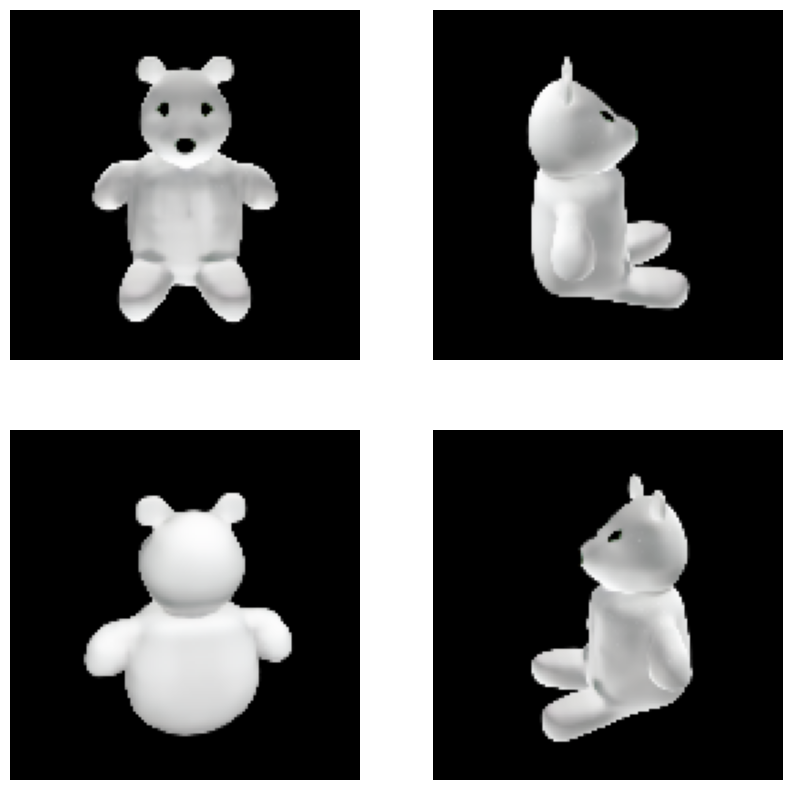

In [ ]:
!git clone https://github.com/openai/shap-e
%cd shap-e
!pip install -e .

import torch
from shap_e.diffusion.sample import sample_latents
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
from shap_e.models.download import load_model, load_config
from shap_e.util.notebooks import create_pan_cameras, decode_latent_images
import matplotlib.pyplot as plt
import os
import warnings
import numpy as np
import scipy

if not (np.__version__ >= '1.23' and scipy.__version__ >= '1.11'):
    warnings.warn("NumPy and SciPy versions may be incompatible. Consider upgrading with `pip install --upgrade numpy scipy`.")
else:
    warnings.filterwarnings("ignore", message="A NumPy version .* is required for this version of SciPy")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

try:
    xm = load_model('transmitter', device=device)
    model = load_model('text300M', device=device)
    diffusion = diffusion_from_config(load_config('diffusion'))
    print("Models loaded successfully.")
except Exception as e:
    print(f"Error loading models: {e}")
    raise

def generate_3d(prompt, size=128, render_mode='nerf', save_mesh=False, output_dir='output'):
    """
    Generate a 3D model from a text prompt and display four images in a 2x2 grid.
    Optionally save the model as a PLY file.

    Args:
        prompt (str): Text description of the 3D model (e.g., "a car").
        size (int): Size of the rendered images (default: 128).
        render_mode (str): Rendering mode, 'nerf' or 'stf' (default: 'nerf').
        save_mesh (bool): If True, save the 3D model as a PLY file (default: False).
        output_dir (str): Directory to save the mesh file (default: 'output').
    """
    batch_size = 1
    guidance_scale = 15.0

    try:
        latents = sample_latents(
            batch_size=batch_size,
            model=model,
            diffusion=diffusion,
            guidance_scale=guidance_scale,
            model_kwargs=dict(texts=[prompt] * batch_size),
            progress=True,
            clip_denoised=True,
            use_fp16=True,
            use_karras=True,
            karras_steps=64,
            sigma_min=1e-3,
            sigma_max=160,
            s_churn=0
        )

        cameras = create_pan_cameras(size, device)
        for i, latent in enumerate(latents):
            images = decode_latent_images(xm, latent, cameras, rendering_mode=render_mode)

            num_images = len(images)
            if num_images >= 4:
                indices = [0, num_images//4, num_images//2, 3*num_images//4]
                fig, axes = plt.subplots(2, 2, figsize=(10, 10))
                for i, ax in enumerate(axes.flat):
                    ax.imshow(images[indices[i]])
                    ax.axis('off')
                plt.show()
            else:
                print("Not enough images to display. Displaying the first image.")
                plt.imshow(images[0])
                plt.axis('off')
                plt.show()

            if save_mesh:
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)

                try:
                    mesh = TriMesh.from_latent(xm, latent)
                    mesh_path = os.path.join(output_dir, f"{prompt.replace(' ', '_')}.ply")
                    mesh.export(mesh_path)
                    print(f"Mesh saved to {mesh_path}")
                except AttributeError:
                    print("Mesh saving not implemented. Check Shap-E API for correct method.")

    except Exception as e:
        print(f"Error generating 3D model for prompt '{prompt}': {e}")

generate_3d("a car", size=128, render_mode='nerf', save_mesh=False)
generate_3d('an airplane that looks like a banana', 256)
generate_3d('a white teddy bear')